In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
import pandas as pd
import gc

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate
from gsnn.optim.EarlyStopper import EarlyStopper
from gsnn.simulate.datasets import simulate_3_in_3_out

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


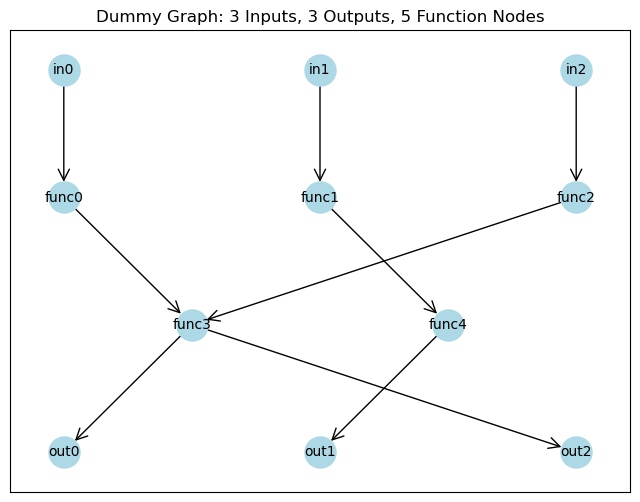

In [2]:
G, pos, x_train, x_test, y_train, y_test, input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=10, n_test=100, noise_scale=0.1, device='cuda')

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

# Performance comparison on simulated data

In [3]:
def train(model, model_params, train_params, x_train, y_train, x_test, y_test, device, max_epochs=500, patience=10): 

    gc.collect() 
    torch.cuda.empty_cache()

    model = model(**model_params).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    crit = torch.nn.MSELoss()

    early_stopper = EarlyStopper(patience=patience, min_delta=1e-3)

    losses = []
    for i in range(max_epochs): 
        model.train()
        optim.zero_grad() 
        yhat = model(x_train)
        loss = crit(y_train, yhat)
        loss.backward() 
        optim.step()

        with torch.no_grad(): 
            model.eval()
            loss = crit(model(x_test), y_test)
            losses.append(loss.item())
            if early_stopper.early_stop(loss): break

    del model; del optim; del crit 

    return losses

def run_search(model, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=10):

    res = {**{k:[] for k in model_params.keys() if k not in ['edge_index_dict', 'node_names_dict']}, **{k:[] for k in training_params.keys()}}
    losses = []
    for i in range(iters): 
        print(f'progress: {i}/{iters}', end='\r')
        
        mp = {k:np.random.choice(model_params[k], size=1).item() for k,v in model_params.items()}
        tp = {k:np.random.choice(training_params[k], size=1).item() for k,v in training_params.items()}
        losses.append( train(model, mp, tp, x_train, y_train, x_test, y_test, device) )

        _=[res[k].append(v) for k,v in mp.items() if k not in ['edge_index_dict', 'node_names_dict']] 
        _=[res[k].append(v) for k,v in tp.items()]

    res = pd.DataFrame(res)
    return res, losses

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
iters = 100

gsnn_search_space = {'channels':np.arange(2, 40).tolist(), 
                'layers':[2,3,4],
                'share_layers':[True, False], 
                'add_function_self_edges':[True, False],
                'norm':['none', 'layer', 'batch', 'softmax'],
                'init':['xavier', 'kaiming'],
                'bias':[True, False], 
                'dropout':[0, 0.1],
                'residual':[True, False]}

gsnn_training_params = {'lr': [1e-1, 1e-2, 1e-3], 
                        'max_epochs':[250], 
                        'device':[device], 
                        'weight_decay':[0, 1e-2, 1e-4, 1e-6]} 

In [6]:
# GSNN with true graph structure
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

model_params = {**{'edge_index_dict':[data.edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn, test_losses_gsnn = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn = res_gsnn.assign(last_loss=[x[-1] for x in test_losses_gsnn], 
                            best_loss=[min(x) for x in test_losses_gsnn]) 


In [7]:
# choose random edges from GSNN graph structure

edge_index_dict = copy.deepcopy(data.edge_index_dict)
E = edge_index_dict['function', 'to', 'function'].size(1)
edge_index_dict['function', 'to', 'function']  = torch.randint(low=0, high=len(function_nodes), size=(2,E))

model_params = {**{'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn_rand, test_losses_gsnn_rand = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn_rand = res_gsnn_rand.assign(last_loss=[x[-1] for x in test_losses_gsnn_rand], 
                            best_loss=[min(x) for x in test_losses_gsnn_rand]) 



In [8]:
# Fully connected GSNN (all nodes connected to each other)

edge_index_dict = copy.deepcopy(data.edge_index_dict)
edge_index_dict['function', 'to', 'function']  = torch.stack((torch.arange(len(function_nodes)).repeat_interleave(len(function_nodes)), 
                                                              torch.arange(len(function_nodes)).repeat(len(function_nodes))), dim=0)

model_params = {**{'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn_full, test_losses_gsnn_full = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn_full = res_gsnn_full.assign(last_loss=[x[-1] for x in test_losses_gsnn_full], 
                            best_loss=[min(x) for x in test_losses_gsnn_full]) 


In [9]:
nn_model_params = {'in_channels':[x_train.size(1)], 
                'out_channels':[y_train.size(1)], 
                'hidden_channels':[10,20,40,80,120], 
                'layers':[1,2],
                'norm':[torch.nn.BatchNorm1d, None],
                'dropout':[0, 0.1, 0.25]}

nn_training_params = {'lr': [1e-2, 1e-3], 
                      'max_epochs':[250], 
                        'device':[device], 
                        'weight_decay':[0, 1e-3, 1e-5]} 

res_nn, losses_nn = run_search(NN, nn_model_params, nn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

In [10]:
print(f'best test loss NN: {min([min(loss) for loss in losses_nn])}')
print(f'best test loss GSNN: {min([min(loss) for loss in test_losses_gsnn])}')
print(f'best test loss GSNN (rand graph): {min([min(loss) for loss in test_losses_gsnn_rand])}')
print(f'best test loss GSNN (fully connected): {min([min(loss) for loss in test_losses_gsnn_full])}')

best test loss NN: 0.4660786986351013
best test loss GSNN: 0.3530624508857727
best test loss GSNN (rand graph): 1.5836840867996216
best test loss GSNN (fully connected): 0.433627188205719


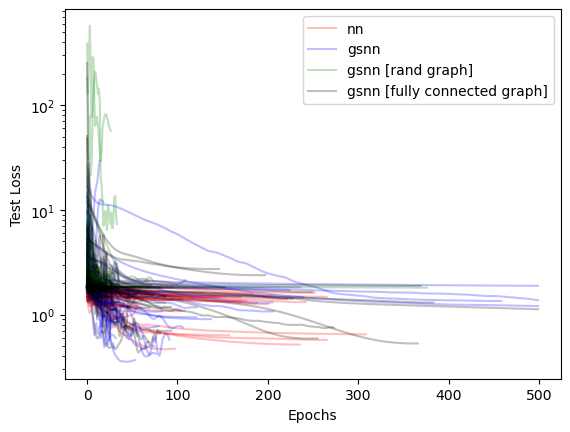

In [11]:
alpha = 0.25

plt.figure()

for i, loss in enumerate(losses_nn): 
    if i == 0: 
        plt.plot(loss, 'r-', label='nn', alpha=alpha)
    else:
        plt.plot(loss, 'r-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn):
    if i == 0: 
        plt.plot(loss, 'b-', label='gsnn', alpha=alpha)
    else:
        plt.plot(loss, 'b-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn_rand):
    if i == 0: 
        plt.plot(loss, 'g-', label='gsnn [rand graph]', alpha=alpha)
    else:
        plt.plot(loss, 'g-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn_full):
    if i == 0: 
        plt.plot(loss, 'k-', label='gsnn [fully connected graph]', alpha=alpha)
    else:
        plt.plot(loss, 'k-', alpha=alpha)

plt.xlabel('Epochs')
plt.ylabel('Test Loss')

#plt.ylim(0.,1.5)
plt.legend()
plt.yscale('log')
plt.show()

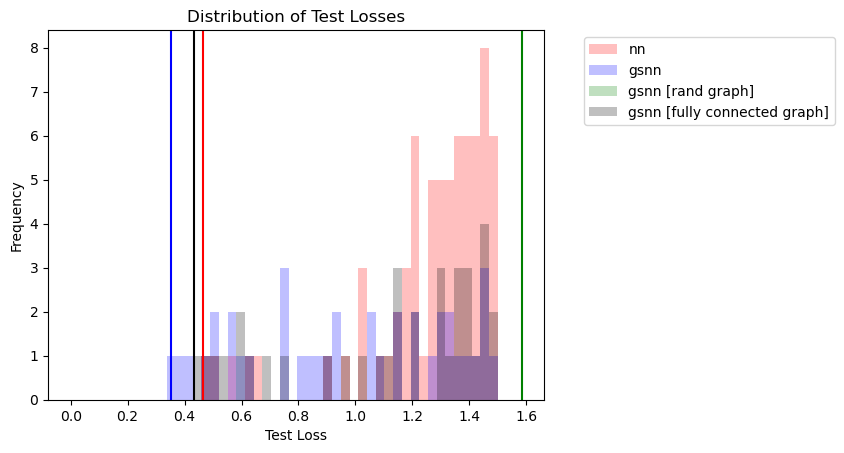

In [12]:
bins = np.linspace(0.,1.5,50)

plt.figure()
plt.hist([min(loss) for loss in losses_nn], label='nn', alpha=0.25, color='r', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn], label='gsnn', alpha=0.25, color='b', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn_rand], label='gsnn [rand graph]', alpha=0.25, color='g', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn_full], label='gsnn [fully connected graph]', alpha=0.25, color='k', bins=bins)

plt.axvline(np.nanmin([min(loss) for loss in losses_nn]),  color='r')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn]),  color='b')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn_rand]),  color='g')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn_full]), color='k')

plt.xlabel('Test Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Test Losses')

# place legend outside 
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))

plt.show()

In [13]:
# best gsnn hyper params 
res_gsnn.sort_values(by='best_loss', ascending=True).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,init,bias,dropout,residual,lr,max_epochs,device,weight_decay,last_loss,best_loss
93,21,2,False,True,batch,xavier,False,0.0,False,0.01,250,cuda,0.000000,0.367729,0.353062
21,14,3,False,False,none,xavier,False,0.0,True,0.01,250,cuda,0.000000,0.421564,0.396301
23,39,4,True,True,none,xavier,False,0.1,False,0.01,250,cuda,0.000000,0.574076,0.405355
36,12,2,True,True,none,kaiming,False,0.1,True,0.01,250,cuda,0.010000,0.498855,0.470864
99,26,2,True,True,none,kaiming,False,0.0,False,0.10,250,cuda,0.000001,0.491387,0.491289
59,23,3,False,True,batch,kaiming,True,0.1,False,0.01,250,cuda,0.000001,0.598254,0.502342
11,20,2,True,False,batch,kaiming,True,0.0,True,0.10,250,cuda,0.000001,2.207957,0.564730
98,31,4,False,False,none,xavier,False,0.0,True,0.01,250,cuda,0.000100,0.679059,0.580175
13,22,4,True,True,none,kaiming,False,0.0,False,0.10,250,cuda,0.000001,0.833762,0.597296
4,35,2,False,True,batch,xavier,True,0.0,True,0.10,250,cuda,0.010000,0.996862,0.636798


In [14]:
res_gsnn.sort_values(by='best_loss', ascending=False).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,init,bias,dropout,residual,lr,max_epochs,device,weight_decay,last_loss,best_loss
85,35,2,True,True,none,kaiming,True,0.1,True,0.100,250,cuda,0.000100,29.473171,3.555199
10,35,3,False,False,batch,xavier,True,0.0,True,0.100,250,cuda,0.000000,11.783001,1.958660
51,10,2,True,False,batch,xavier,False,0.0,False,0.001,250,cuda,0.000000,2.014373,1.888451
1,29,2,False,False,batch,xavier,False,0.0,True,0.010,250,cuda,0.010000,1.998355,1.881346
97,3,1,False,False,softmax,kaiming,False,0.0,True,0.001,250,cuda,0.000100,1.881323,1.881323
74,18,1,True,True,softmax,kaiming,False,0.1,True,0.001,250,cuda,0.000001,1.825060,1.825060
56,29,1,False,False,softmax,kaiming,False,0.0,False,0.001,250,cuda,0.000100,1.817831,1.817831
6,20,4,False,False,batch,kaiming,True,0.1,False,0.001,250,cuda,0.000000,1.819341,1.817282
49,23,3,False,False,none,kaiming,False,0.1,False,0.001,250,cuda,0.010000,1.817163,1.817163
70,35,1,False,True,batch,xavier,False,0.0,False,0.001,250,cuda,0.000000,1.817163,1.817163


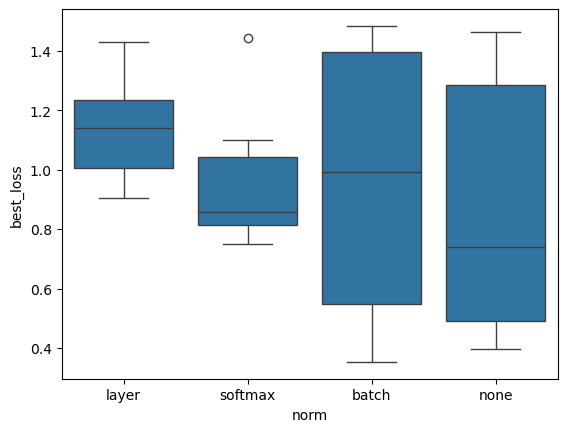

In [15]:
plt.figure()
sbn.boxplot(x='norm', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

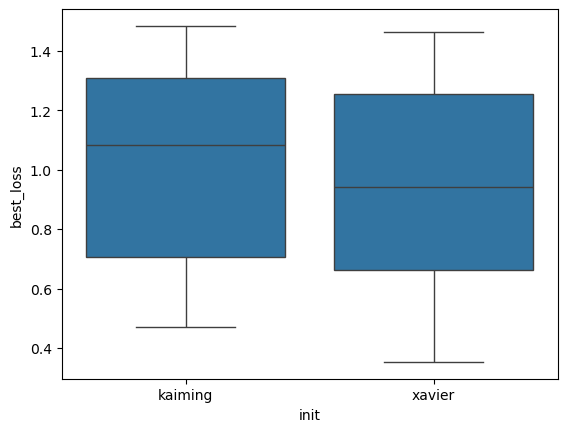

In [16]:
plt.figure() 
sbn.boxplot(x='init', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

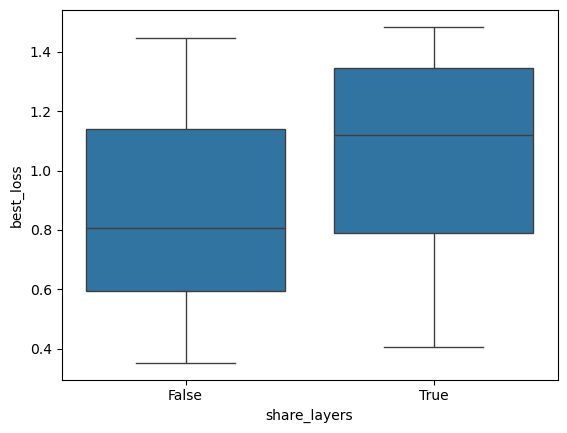

In [17]:
plt.figure() 
sbn.boxplot(x='share_layers', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

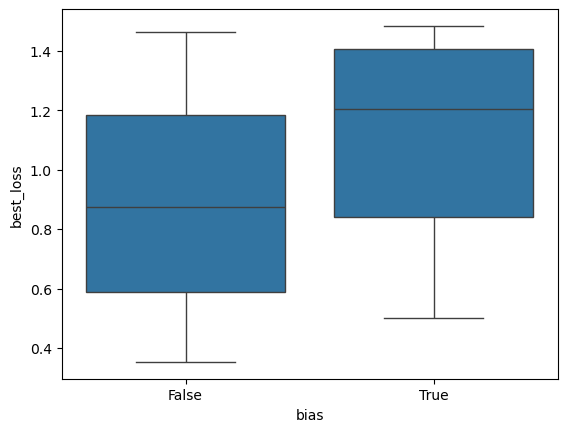

In [18]:
plt.figure() 
sbn.boxplot(x='bias', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

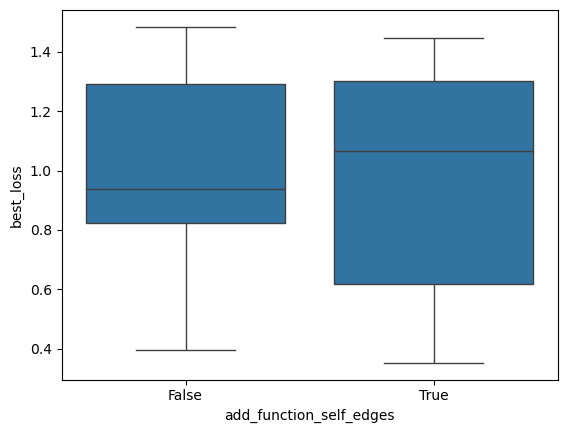

In [19]:
plt.figure() 
sbn.boxplot(x='add_function_self_edges', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

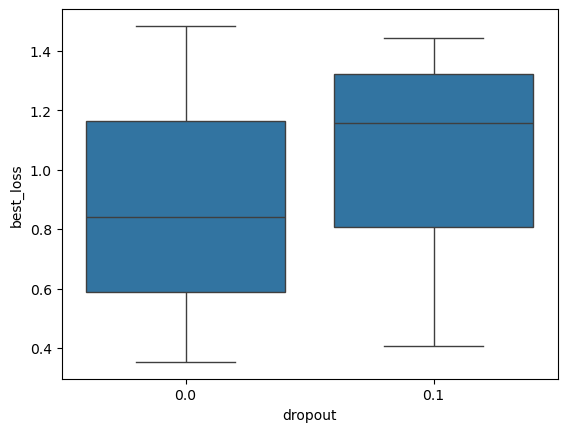

In [20]:
plt.figure() 
sbn.boxplot(x='dropout', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

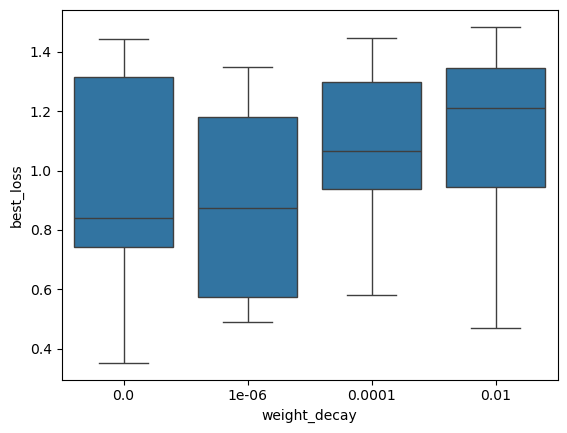

In [21]:
plt.figure() 
sbn.boxplot(x='weight_decay', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

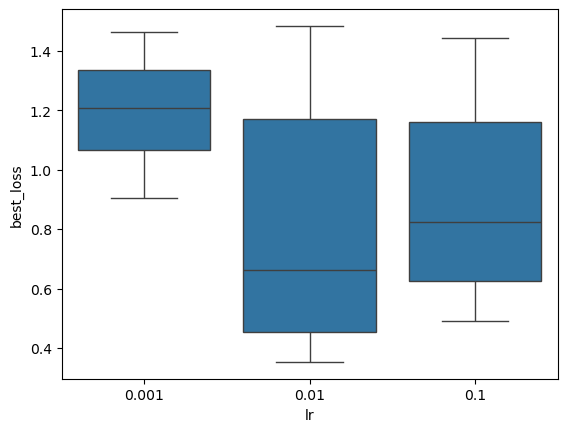

In [22]:
plt.figure() 
sbn.boxplot(x='lr', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

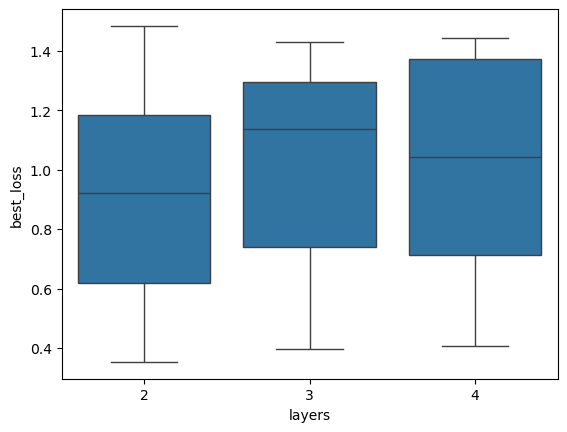

In [23]:
plt.figure() 
sbn.boxplot(x='layers', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

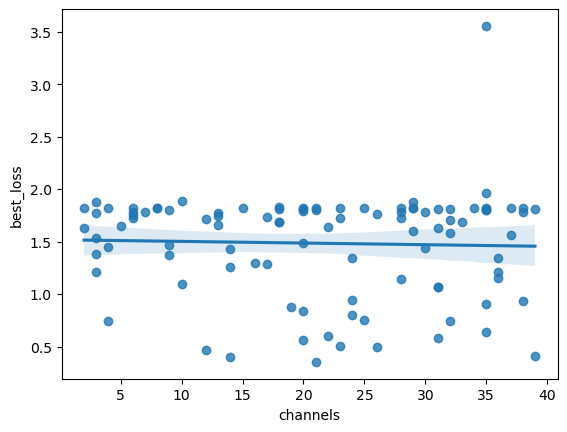

In [24]:
plt.figure() 
sbn.regplot(x='channels', y='best_loss', data=res_gsnn)
plt.show() 

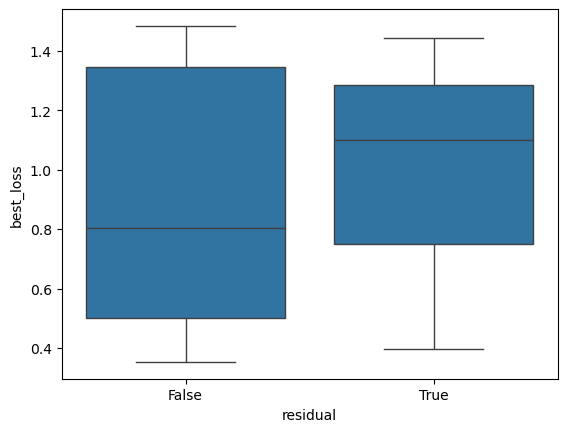

In [25]:
plt.figure() 
sbn.boxplot(x='residual', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 